# Lab 03 Lattice-Boltzmann simulation with ESSPResSo

This notebook installs ESPResSo 4.2 from source, builds it with Python bindings, and runs two simulations.
- 1. Diffusion of a polymer
- 2. Poiseuille flow

In [ ]:
# Install system and Python dependencies
!apt-get update
!apt-get install -y cmake g++ libfftw3-dev libhdf5-dev libboost-all-dev openmpi-bin libopenmpi-dev
!pip install numpy scipy h5py mpi4py

In [ ]:
# Clone ESPResSo 4.2 with submodules
!git clone --recursive --single-branch -b 4.2 https://github.com/espressomd/espresso.git

In [ ]:
# Build ESPResSo
%cd espresso
!mkdir build
%cd build
!cmake .. -DPYTHON=ON -DENABLE_PYTHON=ON -DCMAKE_INSTALL_PREFIX=../install
!make -j2
!make install

In [ ]:
# Setting up the location of the installed packages
!find /content/espresso/install/local/lib -name "site-packages"

In [ ]:
# Add to Python path
import sys
sys.path.append("/content/espresso/install/local/lib/python3.11/dist-packages")

In [ ]:
import logging
import matplotlib.pyplot as plt

# 1. Diffusion of a polymer


## 1.1 Setting up the polymer and observables

The first task is to compute the following parameters for different polymer lengths (from 6 to 14 monomers):

 - **Average hydrodynamic radius** $R_h$
 - **End-to-end distance** $R_F$
 - **Radius of gyration** $R_g$

This will be achieved using the corresponding **observables**, described in the [user guide](https://espressomd.github.io/doc4.2.2/analysis.html)
 under:

**Analysis → Direct analysis routines → Chains**

- espressomd.analyze.Analysis.calc_re(): average end-to-end-distance

- espressomd.analyze.Analysis.calc_rg(): average radius of gyration

- espressomd.analyze.Analysis.calc_rh(): average hydrodynamic radius


The second task is to estimate the following parameter for different polymer lengths (from 6 to 14 monomers).
- **polymer diffusion coefficient**

We will use two methods to calculate this parameter:

- The **center of mass mean squared displacement (MSD)** method (introduced earlier in this tutorial)  
- The **center of mass velocity autocorrelation method** (also known as the **Green–Kubo method**)

To perform this analysis, we can again use the **multiple tau correlator**.


In [ ]:
# Defining the functions:
# 1. build_polymer
# 2. correlator_msd
# 3. correlator_gk
# 4. solvent_langevin
# 5. solvent_lbm

def build_polymer(system, n_monomers, polymer_params, fene):
    positions = espressomd.polymer.linear_polymer_positions(
        beads_per_chain=n_monomers, **polymer_params)
    p_previous = None
    for i, pos in enumerate(positions[0]):
        p = system.part.add(pos=pos)
        if p_previous is not None:
            p.add_bond((fene, p_previous))
        p_previous = p

def correlator_msd(pids_monomers, tau_max):
    com_pos = espressomd.observables.ComPosition(ids=pids_monomers)
    com_pos_cor = espressomd.accumulators.Correlator(
        obs1=com_pos, tau_lin=16, tau_max=tau_max, delta_N=5,
        corr_operation="square_distance_componentwise", compress1="discard1")
    return com_pos_cor


def correlator_gk(pids_monomers, tau_max):
    com_vel = espressomd.observables.ComVelocity(ids=pids_monomers)
    com_vel_cor = espressomd.accumulators.Correlator(
        obs1=com_vel, tau_lin=16, tau_max=tau_max, delta_N=10,
        corr_operation="scalar_product", compress1="discard1")
    return com_vel_cor

def solvent_langevin(system, kT, gamma):
    '''
    Implicit solvation model based on Langevin dynamics (Rouse model).
    '''
    system.thermostat.set_langevin(kT=kT, gamma=gamma, seed=42)


def solvent_lbm(system, kT, gamma):
    '''
    Lattice-based solvation model based on the LBM (Zimm model).
    '''
    lbf = espressomd.lb.LBFluidGPU(kT=kT, seed=42, agrid=1, dens=1,
                                   visc=5, tau=system.time_step)
    system.actors.add(lbf)
    system.thermostat.set_lb(LB_fluid=lbf, gamma=gamma, seed=42)

## 1.2 Simulating the polymer

In [ ]:
# 1.2.1 Importing necessary packages
import logging
import sys
import threading
from pathlib import Path

import numpy as np
import scipy.optimize

import espressomd
import espressomd.analyze
import espressomd.accumulators
import espressomd.observables
import espressomd.polymer

import espressomd.io.writer.vtf   as vtf
import espressomd.visualization   as viz


In [ ]:
# 1.2.2 Logging basic configuration and setting up the Lennard-Jones Potential
logging.basicConfig(level=logging.INFO, stream=sys.stdout)
espressomd.assert_features(['LENNARD_JONES'])

In [ ]:
# 1.2.3 Setting up the trajectory files to visualize the polymer simulation
WRITE_VTF = True
LIVE_VIS  = False
FRAME_EVERY = 200
OUT_DIR = Path("./trajectories").resolve()
OUT_DIR.mkdir(exist_ok=True)

In [ ]:
# 1.2.4 Setting simulation parameters
BOX_L = 16
TIME_STEP = 0.01
LOOPS = 4000
STEPS = 200
KT = 1.0
GAMMA = 5.0
POLYMER_PARAMS = {'n_polymers': 1,
                  'bond_length': 1,
                  'seed': 42,
                  'min_distance': 0.9}
POLYMER_MODEL = 'Rouse'
assert POLYMER_MODEL in ('Rouse', 'Zimm')

if POLYMER_MODEL == 'Zimm':
    espressomd.assert_features(['CUDA'])
    import espressomd.lb

In [ ]:
# 1.2.4 Setting up the simulation system
system = espressomd.System(box_l=[BOX_L]*3)
system.cell_system.skin = 0.4

# Lennard-Jones interaction
system.non_bonded_inter[0, 0].lennard_jones.set_params(
    epsilon=1.0, sigma=1.0, shift="auto", cutoff=2.0**(1/6))

# Fene interaction
fene = espressomd.interactions.FeneBond(k=7, r_0=1, d_r_max=2)
system.bonded_inter.add(fene)

# Number of monomers for each polymer simulation
N_MONOMERS = [6, 8, 10, 12, 14]

# Lists to store the results
com_pos_tau_results = []
com_pos_msd_results = []
com_vel_tau_results = []
com_vel_acf_results = []
rh_results = []
rf_results = []
rg_results = []

In [ ]:
# 1.2.5 Setting up the simulation loop
for N in N_MONOMERS:
    logging.info(f"===  Polymer with {N} monomers  ===")

    # Building a polymer with N_MONOMERS
    build_polymer(system, N, POLYMER_PARAMS, fene)

    # Writing visualization files
    if WRITE_VTF:
        vtf_path = OUT_DIR / f"polymer_{N}.vtf"
        trajfile = vtf_path.open("w+t")
        vtf.writevsf(system, trajfile)          # header once

    if LIVE_VIS:
        viewer = viz.openGLLive(system,
                                bonds=True,
                                particle_coloring='type',
                                window_size=[600, 600])
    # System Equilibration
    system.time_step = 0.002
    system.integrator.set_steepest_descent(f_max=1.0, gamma=10,
                                           max_displacement=0.01)
    system.integrator.run(2000)
    system.integrator.set_vv()

    system.time_step = TIME_STEP
    system.thermostat.set_langevin(kT=1.0, gamma=50, seed=42)
    system.integrator.run(2000)
    system.thermostat.turn_off()

    # Defining the solvent model
    if POLYMER_MODEL == 'Rouse':
        solvent_langevin(system, KT, GAMMA)
    else:
        solvent_lbm(system, KT, GAMMA)

    system.integrator.run(1000)

    # Setting up correlators
    com_pos_cor = correlator_msd(np.arange(N), LOOPS * STEPS)
    system.auto_update_accumulators.add(com_pos_cor)

    com_vel_cor = correlator_gk(np.arange(N), LOOPS * STEPS)
    system.auto_update_accumulators.add(com_vel_cor)

    # Setting up the production run
    rhs = np.zeros(LOOPS)
    rfs = np.zeros(LOOPS)
    rgs = np.zeros(LOOPS)

    for i in range(LOOPS):
        system.integrator.run(STEPS)

        # Refresh every FRAME_EVERY steps
        if WRITE_VTF and (i % (FRAME_EVERY // STEPS) == 0):
            vtf.writevcf(system, trajfile)
        if LIVE_VIS:
            viewer.update()

        # Calculating  rhs, rfs, and rgs
        rhs[i] = system.analysis.calc_rh(chain_start=0,
                                         number_of_chains=1,
                                         chain_length=N)[0]
        rfs[i] = system.analysis.calc_re(chain_start=0,
                                         number_of_chains=1,
                                         chain_length=N)[0]
        rgs[i] = system.analysis.calc_rg(chain_start=0,
                                         number_of_chains=1,
                                         chain_length=N)[0]

    # Finalizing correlators and storing results
    com_pos_cor.finalize()
    com_pos_tau_results.append(com_pos_cor.lag_times())
    com_pos_msd_results.append(np.sum(com_pos_cor.result(), axis=1))

    com_vel_cor.finalize()
    com_vel_tau_results.append(com_vel_cor.lag_times())
    com_vel_acf_results.append(com_vel_cor.result())

    rh_results.append(rhs)
    rf_results.append(rfs)
    rg_results.append(rgs)

    # Cleaning up before next chain length
    if WRITE_VTF:
        trajfile.close()
        logging.info(f"Trajectory written to {vtf_path}")
    if LIVE_VIS:
        viewer.close()

    system.part.clear()
    system.thermostat.turn_off()
    system.actors.clear()
    system.auto_update_accumulators.clear()

# convert the results lists into NumPy arrays for further calculations
rh_results  = np.array(rh_results)
rf_results  = np.array(rf_results)
rg_results  = np.array(rg_results)

com_pos_tau_results = np.array(com_pos_tau_results)
com_pos_msd_results = np.reshape(com_pos_msd_results,
                                 [len(N_MONOMERS), -1])

com_vel_tau_results = np.array(com_vel_tau_results)
com_vel_acf_results = np.reshape(com_vel_acf_results,
                                 [len(N_MONOMERS), -1])

logging.info("Simulation finished; analysis arrays are ready.")

In [ ]:
# 1.2.6 Finding the trajectory files
import os, glob, pprint

# absolute location of the default OUT_DIR
print("Current working dir :", os.getcwd())
print("Expected OUT_DIR   :", os.path.abspath("trajectories"))
print()

# list any .vtf files anywhere under /content  (recursive)
matches = glob.glob("/content/**/*.vtf", recursive=True)
print(f"Found {len(matches)} VTF file(s):")
pprint.pprint(matches)

In [ ]:
# 1.2.7 Saving the trajectory files  and downloading the zip file
# Compress the whole trajectories folder
import shutil
zip_path = "/content/polymer_trajectories.zip"
shutil.make_archive(base_name=zip_path[:-4],  # drop ".zip" for make_archive
                    format="zip",
                    root_dir="/content/espresso/build/trajectories")

# Trigger a browser download
from google.colab import files
files.download(zip_path)

Unzip the file polymer_trajectories and open each file with the VMD software:

You can download the VMD version that better suits your operative system from :

[VMD Mac users](https://www.ks.uiuc.edu/Research/vmd/alpha/)

[VMD Windows users](https://www.ks.uiuc.edu/Development/Download/download.cgi?PackageName=VMD)

Use VMD to visualize the files:

- polymer_6.vtf
- polymer_8.vtf
- polymer_10.vtf
- polymer_12.vtf
- polymer_14.vtf


To visualize each file, click the 'Browse' box to look for the polyemr_6.vtf file.
Once the file is located, select it with the mouse, click the 'OK' box, and then click the 'Load' box.

**You must wait for around 10 seconds until all 4000 frames of each simulation are loaded**

Rotate the simulation box using the mouse to inspect it from different angles.
The expected output will be:

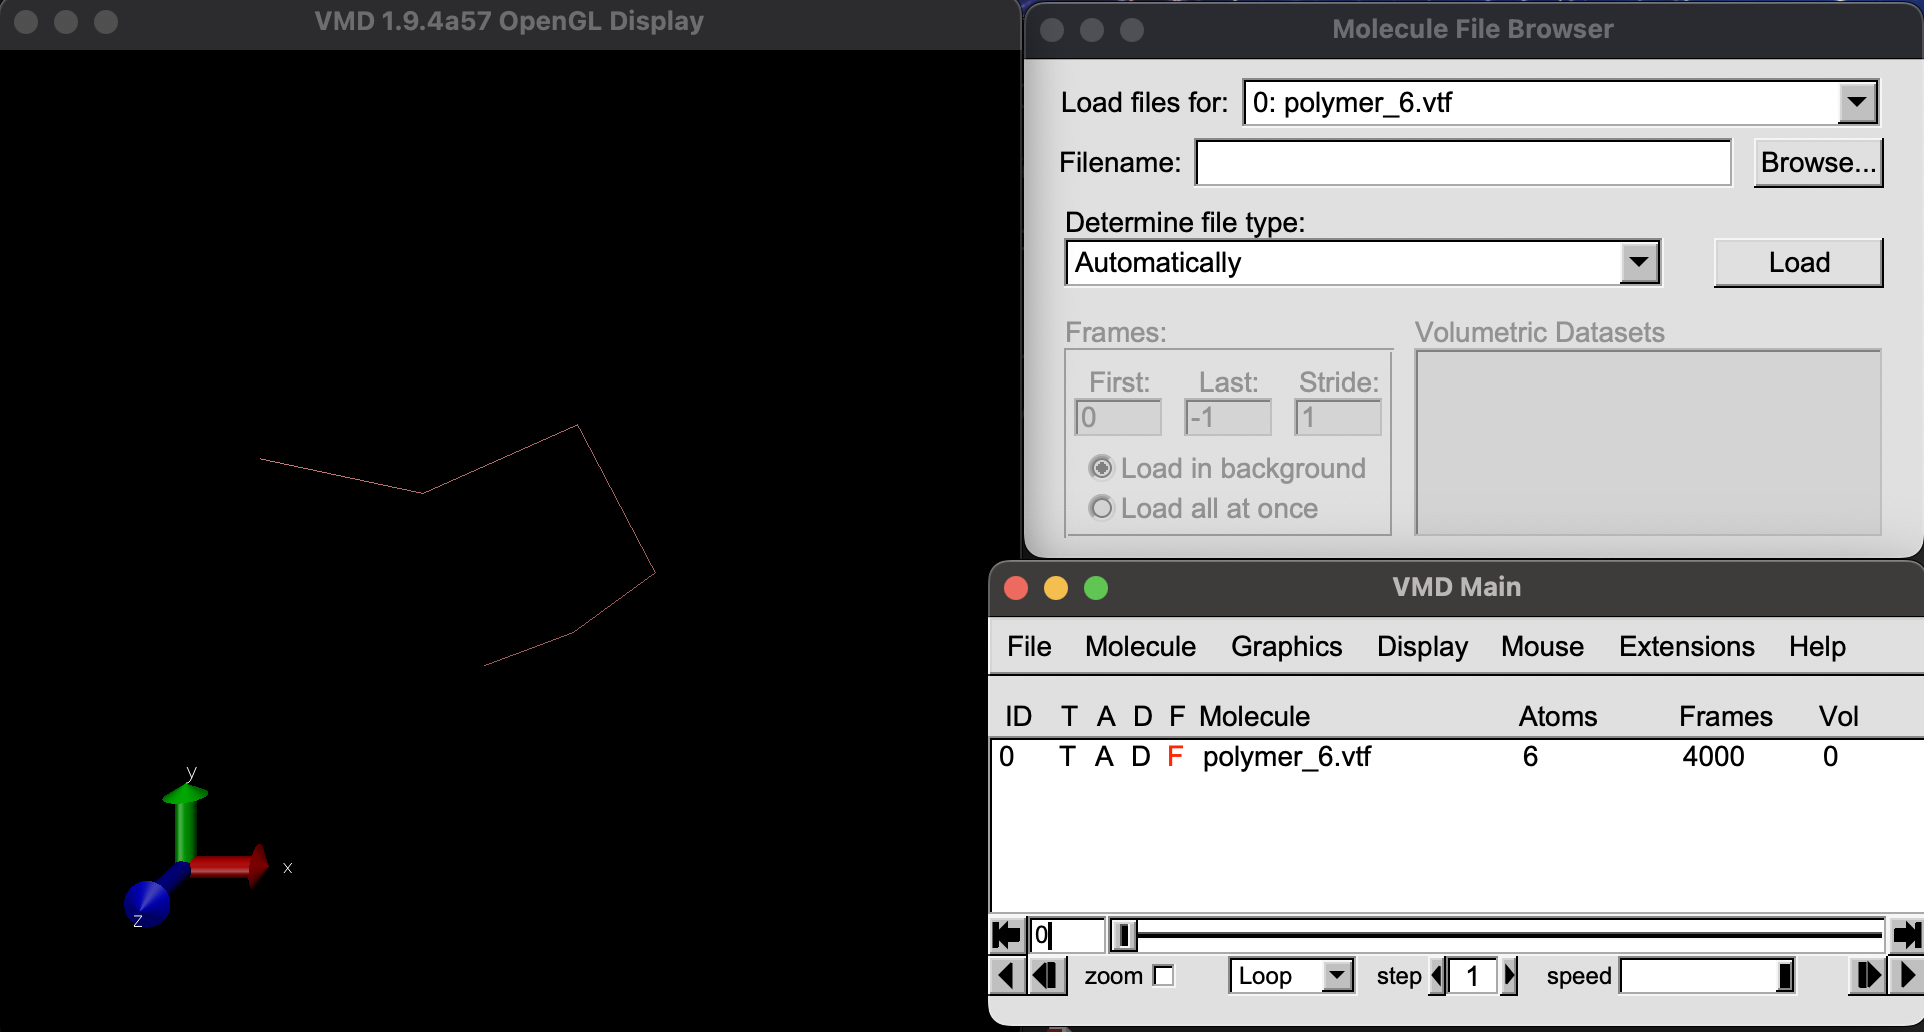

- Select the menu Grapichs/Representations in the window called 'VMD main'. This will open a new window called 'Graphical Representations'.

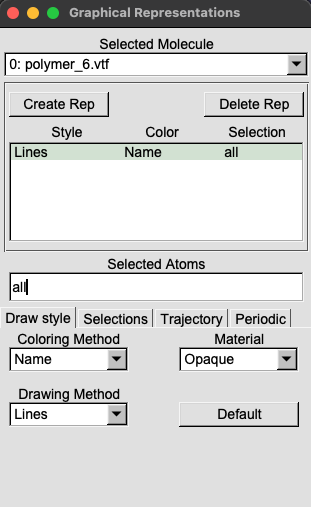

- Press the box 'Create Rep', and a new row will appear under the Style-Color-Selection box
- Change the Drawing Method from 'Lines' to 'VDW', and click the box Apply

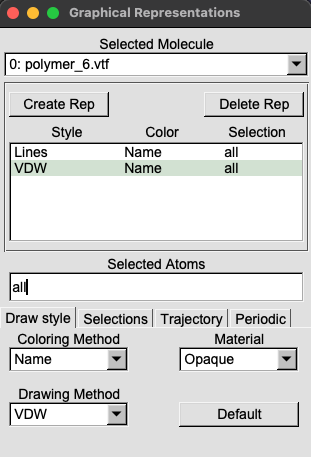

- Rotate the simulation box using the mouse to inspect it from different angles.

The expected output will be:

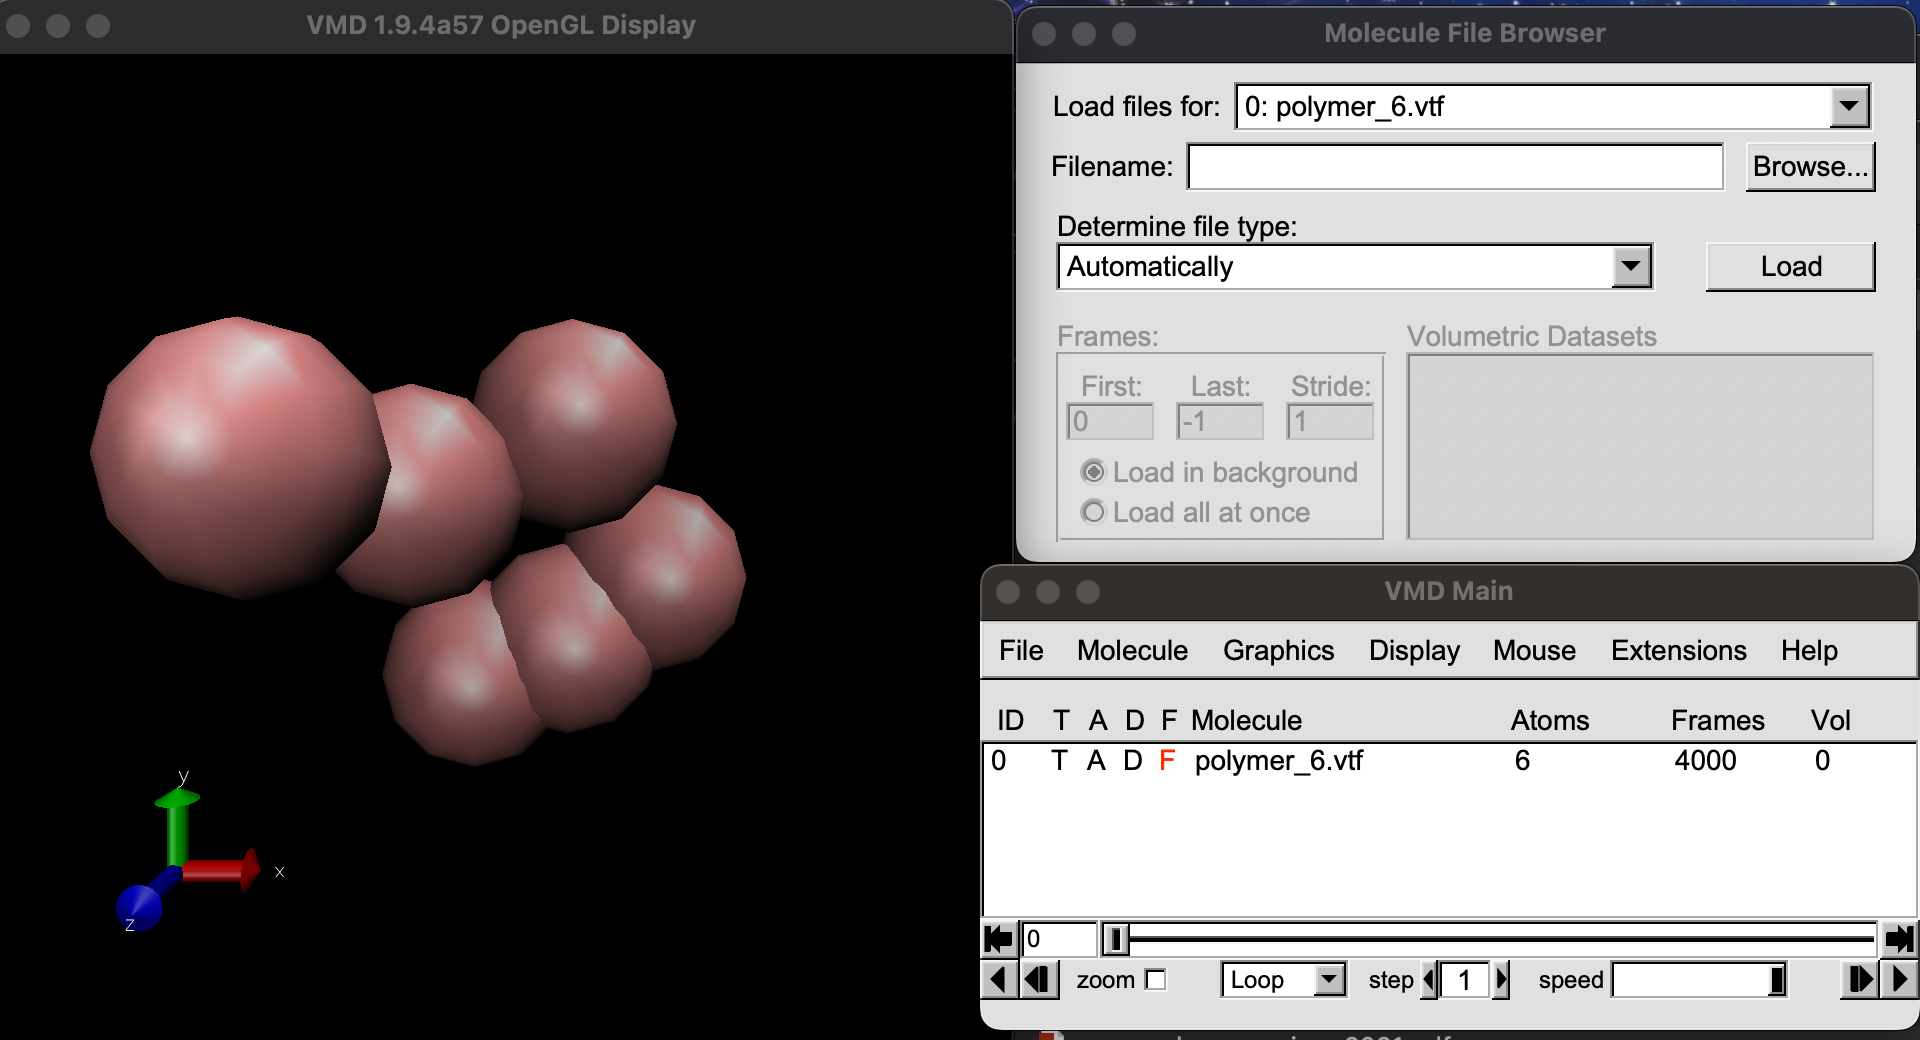

- Click and drag the horizontal bar in the VMD main window to see the trajectory of the simulation
- Zoom out/in if it is necessary to visualize the full trajectory of the polymer

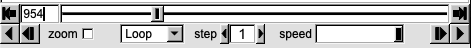

Finally, delete the polymer_8.vtf file by selecting it in the VMD Main window. Then right-click and select the option "Delete molecule"

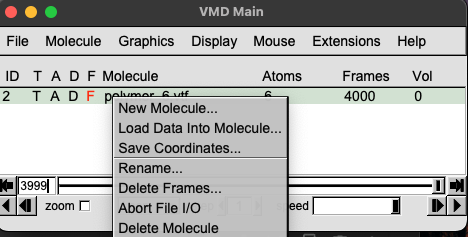

Repeat the procedure to load and visualize the files :
- polymer_8.vtf
- polymer_10.vtf
- polymer_12.vtf
- polymer_14.vtf

## 1.3 Data analysis
We will calculate the means of time series with error bars obtained from the correlation-corrected standard error of the mean [5,6].

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
import matplotlib.ticker as ticker

In [ ]:
plt.rcParams.update({'font.size': 18})

In [ ]:
def standard_error_mean_autocorrelation(time_series, variable_label):
    '''
    Calculate the mean and the correlation-corrected standard error
    of the mean of time series by integrating the autocorrelation
    function. See Janke 2002 [5] and Weigel, Janke 2010 [6].

    Due to the short simulation length, it is not possible to fit an
    exponential to the long-time tail. Instead, return a percentile.
    '''
    summary = []
    fig = plt.figure(figsize=(10, 6))
    for signal, N in zip(time_series, N_MONOMERS):
        acf = espressomd.analyze.autocorrelation(signal - np.mean(signal))
        # the acf cannot be integrated beyond tau=N/2
        integral = np.array([acf[0] + 2 * np.sum(acf[1:j]) for j in np.arange(1, len(acf) // 2)])
        # remove the noisy part of the integral
        negative_number_list = np.nonzero(integral < 0)
        if negative_number_list[0].size:
            integral = integral[:int(0.95 * negative_number_list[0][0])]
        # compute the standard error of the mean
        std_err = np.sqrt(integral / acf.size)
        # due to the small sample size, the long-time tail is not
        # well resolved and cannot be fitted, so we use a percentile
        asymptote = np.percentile(std_err, 75)
        # plot the integral and asymptote
        p = plt.plot([0, len(std_err)], 2 * [asymptote], '--')
        plt.plot(np.arange(len(std_err)) + 1, std_err,
                 '-', color=p[0].get_color(),
                 label=rf'$\int {variable_label}$ for N={N}')
        summary.append((np.mean(signal), asymptote))
    plt.xlabel(r'Lag time $\tau / \Delta t$')
    plt.ylabel(rf'$\int_{{-\tau}}^{{+\tau}} {variable_label}$')
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    plt.legend()
    plt.show()
    return np.array(summary)


def fitting_polymer_theory(polymer_model, n_monomers, diffusion, rh_exponent):
    '''
    Fit the appropriate polymer diffusion coefficient equation (Rouse or
    Kirkwood-Zimm).
    '''
    def rouse(x, a):
        return a / x

    def kirkwood_zimm(x, a, b, exponent):
        return a / x + b / x**exponent

    x = np.linspace(min(n_monomers) - 0.5, max(n_monomers) + 0.5, 20)

    if polymer_model == 'Rouse':
        popt, _ = scipy.optimize.curve_fit(rouse, n_monomers, diffusion)
        label = rf'$D^{{\mathrm{{fit}}}} = \frac{{{popt[0]:.2f}}}{{N}}$'
        y = rouse(x, popt[0])
    elif polymer_model == 'Zimm':
        fitting_function = kirkwood_zimm
        popt, _ = scipy.optimize.curve_fit(
            lambda x, a, b: kirkwood_zimm(x, a, b, rh_exponent), n_monomers, diffusion)
        y = kirkwood_zimm(x, popt[0], popt[1], rh_exponent)
        label = f'''\
        $D^{{\\mathrm{{fit}}}} = \
            \\frac{{{popt[0]:.2f}}}{{N}} + \
            \\frac{{{popt[1] * 6 * np.pi:.3f} }}{{6\\pi}} \\cdot \
            \\frac{{{1}}}{{N^{{{rh_exponent:.2f}}}}}$ \
        '''
    return x, y, label, popt

## 1.3.1 Distance-based macromolecular properties

How do  $R_h$, $R_g$, $R_F$, and the diffusion coefficient \( D \) depend on the number of monomers?  
You can refer to the **Flory theory of polymers**, and assume you are simulating a real polymer in a good solvent, with Flory exponent \( \nu \approx 0.588 \).

---

**Task:**  
Plot the end-to-end distance $R_F$ of the polymer as a function of the number of monomers.  
What relation do you observe?

---

The end-to-end distance follows the scaling law:

$$
R_F = c_F N^{\nu}
$$

where:
- $R_F$ is the end-to-end distance,  
- $c_F$ is a constant,  
- $N$ is the number of monomers,  
- $\nu \approx 0.588$ is the Flory exponent.


In [ ]:
rf_summary = standard_error_mean_autocorrelation(rf_results, r'\operatorname{acf}(R_F)')
rf_exponent, rf_prefactor = np.polyfit(np.log(N_MONOMERS), np.log(rf_summary[:, 0]), 1)
rf_prefactor = np.exp(rf_prefactor)

fig = plt.figure(figsize=(10, 6))
x = np.linspace(min(N_MONOMERS) - 0.5, max(N_MONOMERS) + 0.5, 20)
plt.plot(x, rf_prefactor * x**rf_exponent, '-',
         label=rf'$R_F^{{\mathrm{{fit}}}} = {rf_prefactor:.2f} N^{{{rf_exponent:.2f}}}$')
plt.errorbar(N_MONOMERS, rf_summary[:, 0],
             yerr=rf_summary[:, 1],
             ls='', marker='o', capsize=5, capthick=1,
             label=r'$R_F^{\mathrm{simulation}}$')
plt.xlabel('Number of monomers $N$')
plt.ylabel(r'End-to-end distance [$\sigma$]')
plt.legend()
plt.show()

Plot the **radius of gyration** \( R_g \)  of the polymer as a function of the number of monomers.  
What relation do you observe?

---

The radius of gyration follows the scaling law:

$$
R_g = c_g N^{\nu}
$$

where:
- \( R_g \) is the radius of gyration,  
- \( c_g \) is a constant,  
- \( N \) is the number of monomers,  
- \( \nu \approx 0.588 \) is the Flory exponent.


In [ ]:
rg_summary = standard_error_mean_autocorrelation(rg_results, r'\operatorname{acf}(R_g)')
rg_exponent, rg_prefactor = np.polyfit(np.log(N_MONOMERS), np.log(rg_summary[:, 0]), 1)
rg_prefactor = np.exp(rg_prefactor)

fig = plt.figure(figsize=(10, 6))
x = np.linspace(min(N_MONOMERS) - 0.5, max(N_MONOMERS) + 0.5, 20)
plt.plot(x, rg_prefactor * x**rg_exponent, '-',
         label=rf'$R_g^{{\mathrm{{fit}}}} = {rg_prefactor:.2f} N^{{{rg_exponent:.2f}}}$')
plt.errorbar(N_MONOMERS, rg_summary[:, 0],
             yerr=rg_summary[:, 1],
             ls='', marker='o', capsize=5, capthick=1,
             label=r'$R_g^{\mathrm{simulation}}$')
plt.xlabel('Number of monomers $N$')
plt.ylabel(r'Radius of gyration [$\sigma$]')
plt.legend()
plt.show()

For an **ideal polymer**, the relationship between the end-to-end distance and the radius of gyration is:

$$
\frac{R_F^2}{R_g^2} = 6
$$

In [ ]:
rf2_rg2_ratio = rf_summary[:, 0]**2 / rg_summary[:, 0]**2
print(np.around(rf2_rg2_ratio, 1))

Plot the **hydrodynamic radius** \( R_h \) of the polymers as a function of the number of monomers.  
What relation do you observe?

---

The hydrodynamic radius can be calculated via the **Stokes radius**, i.e., the radius of a sphere that diffuses at the same rate as the polymer.  
An approximate formula is:

$$
R_h \approx c_h N^{1/3}
$$

where:
- \( R_h \) is the hydrodynamic radius,  
- \( c_h \) is a constant,  
- \( N \) is the number of monomers.


In [ ]:
rh_summary = standard_error_mean_autocorrelation(rh_results, r'\operatorname{acf}(R_h)')
rh_exponent, rh_prefactor = np.polyfit(np.log(N_MONOMERS), np.log(rh_summary[:, 0]), 1)
rh_prefactor = np.exp(rh_prefactor)

fig = plt.figure(figsize=(10, 6))
x = np.linspace(min(N_MONOMERS) - 0.5, max(N_MONOMERS) + 0.5, 20)
plt.plot(x, rh_prefactor * x**rh_exponent, '-',
         label=rf'$R_h^{{\mathrm{{fit}}}} = {rh_prefactor:.2f} N^{{{rh_exponent:.2f}}}$')
plt.errorbar(N_MONOMERS, rh_summary[:, 0],
             yerr=rh_summary[:, 1],
             ls='', marker='o', capsize=5, capthick=1,
             label=r'$R_h^{\mathrm{simulation}}$')
plt.xlabel('Number of monomers $N$')
plt.ylabel(r'Hydrodynamic radius [$\sigma$]')
plt.legend()
plt.show()

## 1.3.2 Diffusion coefficient using the MSD method

Calculate the **diffusion coefficient** of the polymers using the **mean-squared displacement (MSD)**.

---

Recalling that for large \( t \), the diffusion coefficient \( D \) can be expressed as:

$$
6D = \lim_{t \to \infty} \frac{\partial \, \text{MSD}(t)}{\partial t}
$$

This is simply the **slope of the MSD** in the **diffusive regime**.

In [ ]:
# cutoff for the diffusive regime (approximative)
tau_f_index = 40
# cutoff for the data series (larger lag times have larger variance due to undersampling)
tau_max_index = 70

plt.figure(figsize=(10, 10))
plt.xlabel(r'$\tau$ [$\Delta t$]')
plt.ylabel(r'MSD [$\sigma^2$]')
for index, (tau, msd) in enumerate(zip(com_pos_tau_results, com_pos_msd_results)):
    plt.loglog(tau[1:120], msd[1:120], label=f'N={N_MONOMERS[index]}')
plt.loglog(2 * [tau[tau_f_index]], [0, np.max(com_pos_msd_results)], '-', color='black')
plt.text(tau[tau_f_index], np.max(com_pos_msd_results), r'$\tau_{f}$')
plt.loglog(2 * [tau[tau_max_index]], [0, np.max(com_pos_msd_results)], '-', color='black')
plt.text(tau[tau_max_index], np.max(com_pos_msd_results), r'$\tau_{max}$')
plt.legend()
plt.show()

In [ ]:
diffusion_msd = np.zeros(len(N_MONOMERS))
plt.figure(figsize=(10, 8))
weights = com_pos_cor.sample_sizes()
for index, (tau, msd) in enumerate(zip(com_pos_tau_results, com_pos_msd_results)):
    a, b = np.polyfit(tau[tau_f_index:tau_max_index], msd[tau_f_index:tau_max_index],
                      1, w=weights[tau_f_index:tau_max_index])
    x = np.array([tau[1], tau[tau_max_index - 1]])
    p = plt.plot(x, a * x + b, '-')
    plt.plot(tau[1:tau_max_index], msd[1:tau_max_index], 'o', color=p[0].get_color(),
             label=rf'$N=${N_MONOMERS[index]}')
    diffusion_msd[index] = a / 6
plt.xlabel(r'$\tau$ [$\Delta t$]')
plt.ylabel(r'MSD [$\sigma^2$]')
plt.legend()
plt.show()

Plot the dependence of the **diffusion coefficient** on the **hydrodynamic radius**.

---

Recall the formula for the diffusion coefficient of a short polymer in the **Kirkwood–Zimm model**:

$$
D = \frac{D_0}{N} + \frac{k_B T}{6 \pi \eta \langle \frac{1}{R_h} \rangle}
$$

where:
- $D$ is the polymer diffusion coefficient,  
- $D_0 = \frac{k_B T}{\gamma} $ is the monomer diffusion coefficient,  
- $\gamma $ is the fluid friction coefficient,  
- $\eta $ is the fluid viscosity,  
- $R_h $ is the hydrodynamic radius.

For the **Rouse regime** (implicit solvent), the second term disappears.

---

**Hint:**

- For the **Rouse regime**, use:  
  $$
  D = \alpha N^{-1}
  $$
  and solve for $ \alpha $.

- For the **Zimm regime**, use:  
  $$
  D = \frac{\alpha_1}{N} + \alpha_2 N^{-\beta}
  $$
  where:
  - $ \beta $ is the **rh_exponent**,  
  - Solve for $ \alpha_1 $ and $ \alpha_2 $.


In [ ]:
fig = plt.figure(figsize=(10, 6))
x, y, label, popt_msd = fitting_polymer_theory(POLYMER_MODEL, N_MONOMERS, diffusion_msd, rh_exponent)
plt.plot(x, y, '-', label=label)
plt.plot(N_MONOMERS, diffusion_msd, 'o', label=r'$D^{\mathrm{simulation}}$')
plt.xlabel('Number of monomers $N$')
plt.ylabel(r'Diffusion coefficient [$\sigma^2/t$]')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.legend()
plt.show()

### 1.3.3 Diffusion coefficient using the Green–Kubo method

Plot the **autocorrelation function (ACF)** and check that the decay is roughly **exponential**.

---

**Hint:**

Use the model:

$$
D = \alpha e^{-\beta \tau}
$$

and solve for $ \alpha $ and $ \beta $.

- You can **leave out the first data point** in the ACF if necessary.
- Limit the fit to the **stable region within the first 20 data points**.


In [ ]:
def exponential(x, a, b):
    return a * np.exp(-b * x)


fig = plt.figure(figsize=(10, 8))
for N, tau, acf in zip(N_MONOMERS, com_vel_tau_results, com_vel_acf_results):
    popt, _ = scipy.optimize.curve_fit(exponential, tau[:20], acf[:20])
    x = np.linspace(tau[0], tau[20 - 1], 100)
    p = plt.plot(x, exponential(x, *popt), '-')
    plt.plot(tau[:20], acf[:20], 'o',
             color=p[0].get_color(), label=rf'$R(\tau)$ for N = {N}')
plt.xlabel(r'$\tau$')
plt.ylabel('Autocorrelation function')
plt.legend()
plt.show()

The **Green–Kubo integral** for the diffusion coefficient takes the following form:

$$
D = \frac{1}{3} \int_0^{+\infty} \langle \vec{v}_c(\tau) \cdot \vec{v}_c(0) \rangle \, d\tau
$$

Since our simulation is **finite in time**, we need to integrate up to a cutoff time \( \tau_{\text{int}} \).

---

To find the **optimal value** of $ \tau_{\text{int}} $:

- Plot the integral as a function of $ \tau_{\text{int}} $.
- Look for a **plateau region** in the plot.
- This plateau is usually followed by **strong oscillations** caused by **low statistics** in the **long-time tail** of the autocorrelation function.


In [ ]:
diffusion_gk = []
fig = plt.figure(figsize=(10, 6))
for N, tau, acf in zip(N_MONOMERS, com_vel_tau_results, com_vel_acf_results):
    x = np.arange(2, 28)
    y = [1 / 3 * np.trapz(acf[:j], tau[:j]) for j in x]
    plt.plot(tau[x], y, label=rf'$D(\tau_{{\mathrm{{int}}}})$ for $N = {N}$')
    diffusion_gk.append(np.mean(y[10:]))
plt.xlabel(r'$\tau_{\mathrm{int}}$')
plt.ylabel(r'$\frac{1}{3} \int_{\tau=0}^{\tau_{\mathrm{int}}} \left<\vec{v_c}(\tau)\cdot\vec{v_c}(0)\right>\, \mathrm{d}\tau$')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 8))
x, y, label, popt_gk = fitting_polymer_theory(POLYMER_MODEL, N_MONOMERS, diffusion_gk, rh_exponent)
plt.plot(x, y, '-', label=label)
plt.plot(N_MONOMERS, diffusion_gk, 'o', label=r'$D^{\mathrm{simulation}}$')
plt.xlabel('Number of monomers $N$')
plt.ylabel(r'Diffusion coefficient [$\sigma^2/t$]')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.legend()
plt.show()

Let us compare the value of the diffusion coefficients calculated with the MSD and Green–Kubo methods:

In [ ]:
print(f'N\tMSD\t\tGK\t\tdifference')
for N, d_msd, d_gk in zip(N_MONOMERS, diffusion_msd, diffusion_gk):
    print(f'{N}\t{d_msd:.2e}\t{d_gk:.2e}\t{np.ceil(np.abs(d_msd-d_gk) * 100 / d_msd):.0f}%')

References
[1] P. G. de Gennes. Scaling Concepts in Polymer Physics. Cornell University Press, Ithaca, NY, 1979.
[2] M. Doi. Introduction to Polymer Physics. Clarendon Press, Oxford, 1996.
[3] Michael Rubinstein and Ralph H. Colby. Polymer Physics. Oxford University Press, Oxford, UK, 2003. ISBN: 978-0-19-852059-7
[4] Daan Frenkel and Berend Smit. Understanding Molecular Simulation, section 4.4.1. Academic Press, San Diego, second edition, 2002.
[5] W. Janke, Statistical analysis of simulations: Data correlations and error estimation, Quantum Simulations of Complex Many-Body Systems: From Theory to Algorithms, Lecture Notes, J. Grotendorst, D. Marx, A. Muramatsu (Eds.), John von Neumann Institute for Computing, 10:423–445, 2002. https://www.physik.uni-leipzig.de/~janke/Paper/nic10_423_2002.pdf
[6] M. Weigel, W. Janke, Error estimation and reduction with cross correlations, Phys. Rev. E, 81:066701, 2010, doi:10.1103/PhysRevE.81.066701; Erratum-ibid 81:069902, 2010, doi:10.1103/PhysRevE.81.069902.

Questions?

- what is autocorrleation function? Why we needes here to calculate different properties?

- Can you describe the autocorrleation function profiles for the diffusion coefficient calculation?

# 2. Poiseuille flow in ESPResSo

**2.1.1 Setting up the system**

In [ ]:
import numpy as np

import espressomd
import espressomd.lb
import espressomd.lbboundaries
import espressomd.shapes

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

#espressomd.assert_features(['LB_BOUNDARIES_GPU'])

# System constants
BOX_L = 16.0
TIME_STEP = 0.01

#system = espressomd.System(box_l=[BOX_L] * 3)
system.time_step = TIME_STEP
system.cell_system.skin = 0.4

**2.1.2 Setting up the lattice-Boltzmann fluid**

In [ ]:
# LB parameters
AGRID = 0.5
VISCOSITY = 2.0
FORCE_DENSITY = [0.0, 0.001, 0.0]
DENSITY = 1.5

# LB boundary parameters
WALL_OFFSET = AGRID

In [ ]:
logging.info("Setup LB fluid.")
lbf = espressomd.lb.LBFluid(agrid=AGRID, dens=DENSITY, visc=VISCOSITY, tau=TIME_STEP,
                               ext_force_density=FORCE_DENSITY)
system.actors.add(lbf)

Create a LB boundary and append it to the list of system LB boundaries.

In [ ]:
logging.info("Setup LB boundaries.")
top_wall = espressomd.shapes.Wall(normal=[1, 0, 0], dist=WALL_OFFSET)
bottom_wall = espressomd.shapes.Wall(normal=[-1, 0, 0], dist=-(BOX_L - WALL_OFFSET))

top_boundary = espressomd.lbboundaries.LBBoundary(shape=top_wall)
bottom_boundary = espressomd.lbboundaries.LBBoundary(shape=bottom_wall)

system.lbboundaries.add(top_boundary)
system.lbboundaries.add(bottom_boundary)

**2.1.3. SimulationLinks to an external site.**
We will now simulate the fluid flow until we reach the steady state.

In [ ]:
logging.info("Iterate until the flow profile converges (5000 LB updates).")
system.integrator.run(5000)

**2.1.4. Data analysisLinks to an external site.**
We can now extract the flow profile and compare it to the analytical solution for the planar Poiseuille flow.

In [ ]:
import matplotlib.pyplot as plt
# Extract fluid velocity along the x-axis
fluid_velocities = np.zeros((lbf.shape[0], 2))
for x in range(lbf.shape[0]):
    # Average over the node in y direction
    v_tmp = np.zeros(lbf.shape[1])
    for y in range(lbf.shape[1]):
        v_tmp[y] = lbf[x, y, 0].velocity[1]
    fluid_velocities[x, 0] = (x + 0.5) * AGRID
    fluid_velocities[x, 1] = np.average(v_tmp)


def poiseuille_flow(x, force_density, dynamic_viscosity, height):
    return force_density / (2.0 * dynamic_viscosity) * \
        (height**2.0 / 4.0 - x**2.0)


x_values = np.linspace(0.0, BOX_L, lbf.shape[0])
HEIGHT = BOX_L - 2.0 * AGRID

# Note that the LB viscosity is not the dynamic viscosity but the
# kinematic viscosity (mu=LB_viscosity * density)
plt.plot(
    x_values,
    poiseuille_flow(x_values - (HEIGHT / 2.0 + AGRID),
                    FORCE_DENSITY[1],
                    VISCOSITY * DENSITY,
                    HEIGHT),
    'o-',
    label='analytical')
plt.plot(fluid_velocities[:, 0], fluid_velocities[:, 1], label='simulation')
plt.legend()
plt.show()


**2.1.5. Analysis for the report**
Now in the figure you obtained from section 4, the simulated flow profile was compared against the analytical solution for the planar Poiseuille flow. Do you see they compared well?

Now, save this graph and take note of the maximum velocity. Question: Where is the maximum velocity located and why is that?

In section, 2.1.2, check the LB parameters used for the simulations. What would be the impact of changing some of those parameters such as viscosity and y-force constants? Can you change those values and show thir relationship with maximum velocity?